### **Imports**

In [0]:
import pandas as pd
from sklearn import model_selection
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import *

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.imagenet_utils import preprocess_input
from keras.regularizers import *
'''
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!

gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)
'''
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

Using TensorFlow backend.


### **Mount & set directory**


In [0]:
home_dir = '/home/carkyo/Downloads/FER/'

baum_dir = home_dir + 'BAUM/'
data = pd.read_csv(baum_dir + 'training_data_mixed.csv', dtype={'flow': str, 'spatial': str, 'code': str})
data_valid = pd.read_csv(baum_dir + 'validation_data_mixed.csv', dtype={'flow': str, 'spatial': str, 'code': str})

print("Original data", len(data),  len(data_valid))

'''
data.sort_values(by=['flow'])
data_valid.sort_values(by=['flow'])
data = data.iloc[range(0,len(data),3)]
data_valid = data_valid.iloc[range(0,len(data_valid),2)]

data = shuffle(data)
data_valid = shuffle(data_valid)

#start = 4200; end = 4300
#print(data['flow'][start:end].values)
#print(data['code'][start:end].values)
'''
'''
print("Less data", len(data),  len(data_valid))
def sampling_k_elements(group, k=3500):
    if len(group) < k:
        return group
    return group.sample(k)

def sampling_k_elements_valid(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

data = data.groupby('code').apply(sampling_k_elements).reset_index(drop=True) # It shuffles data / take random k
data_valid = data_valid.groupby('code').apply(sampling_k_elements_valid).reset_index(drop=True)
print("Less data", len(data),  len(data_valid))

'''
data = shuffle(data)
data_valid = shuffle(data_valid)


Original data 64797 9199


### **Image generators**

In [0]:

#############################
#New ###?###
#X_train, X_train_flow, y_train = data['spatial'], data['flow'], data['code']
#X_test, X_test_flow, y_test = data_valid['spatial'], data_valid['flow'], data_valid['code']

#Temporary configration ( has some problems due to shuffling)

train_df, valid_df = data , data_valid
#train_df, valid_df = model_selection.train_test_split(data, test_size=0.25)
# first 10 rows code
'''
X_train, X_test, y_train, y_test = model_selection.train_test_split(data['spatial'], data['code'], test_size=0.25)
X_train_flow, X_test_flow, y_train_flow, y_test_flow = model_selection.train_test_split(data_valid['flow'], data_valid['code'], test_size=0.25)



train_df = pd.concat([X_train, y_train], axis=1, sort=False)
train_df_flow = pd.concat([X_train_flow, y_train_flow], axis=1, sort=False)
valid_df = pd.concat([X_test, y_test], axis=1, sort=False)
valid_df_flow = pd.concat([X_test_flow, y_test_flow], axis=1, sort=False)
'''

#############################

batch_size_ = 256 # 256
target_size_ = 48 # 48
train_datagen = ImageDataGenerator(rescale=1./255)
     #   rescale=1./255,
     #   shear_range=0.2,
     #   zoom_range=0.2,
     #   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_spatial = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(target_size_, target_size_),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_spatial = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(target_size_, target_size_),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

train_generator_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(target_size_, target_size_),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

validation_generator_flow = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(target_size_, target_size_),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

def combine_generator(gen1, gen2):
    while True:    
        X1i = gen1.next()
        X2i = gen2.next()
        frame = X1i[0][0]
        yield [X1i[0], X2i[0]], X1i[1]  

train_generator = combine_generator(train_generator_spatial, train_generator_flow)
validation_generator = combine_generator(validation_generator_spatial, validation_generator_flow)

validation_generator_spatial_2 = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(target_size_, target_size_),
        batch_size=batch_size_,
        class_mode='categorical',
        shuffle = False)

print ("generators initiaized")


Found 64797 validated image filenames belonging to 6 classes.
Found 9199 validated image filenames belonging to 6 classes.
Found 64797 validated image filenames belonging to 6 classes.
Found 9199 validated image filenames belonging to 6 classes.
Found 9199 validated image filenames belonging to 6 classes.
generators initiaized


In [0]:
# Test generator 
import numpy as np
#print(train_df['code'][200:220])
start = 0
end = 10
#print(train_df['flow'][start:end].values)
#print("\n",train_df['spatial'][start:end].values)
#print(train_df['code'][start:end].values)

##s = train_generator_spatial.next()
#x = next(train_generator)
#np.argmax(x[1][0:10], axis = 1)

### **Model & setting**

In [0]:
# Create Model
  # experiment 6 , 7
def create_model():
  input_spatial = Input(shape=(48,48,3))
  x = Conv2D(128, (5, 5), activation='relu')(input_spatial)
  x = MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  x = Conv2D(256, (3, 3), activation='relu')(x)
  x = Conv2D(256, (3, 3), activation='relu')(x)

  Out_spatial = GlobalAveragePooling2D()(x)

    
  input_flow = Input(shape=(48,48,3))
  x = Conv2D(128, (5, 5), activation='relu')(input_flow)
  x = MaxPooling2D(pool_size=(5,5), strides=(2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = AveragePooling2D(pool_size=(3,3), strides=(2, 2))(x)
  x = Conv2D(256, (3, 3), activation='relu')(x)
  x = Conv2D(256, (3, 3), activation='relu')(x)

  Out_flow = GlobalAveragePooling2D()(x)

  merged1 = layers.average([Out_spatial, Out_flow])

  x = Dense(1024, activation='relu')(merged1)
  x = Dropout(0.1)(x)
  x = Dense(1024, activation='relu',
                kernel_regularizer=l2(0.05))(x)

  x = Dropout(0.1)(x)

  Out = Dense(6, activation='softmax')(x)

  model = models.Model(inputs=[input_spatial, input_flow], outputs=[Out])
  return model
  
model = create_model()



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### **Train**

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 44, 44, 128)  9728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 44, 44, 128)  9728        input_2[0][0]                    
______________________________________________________________________________________________

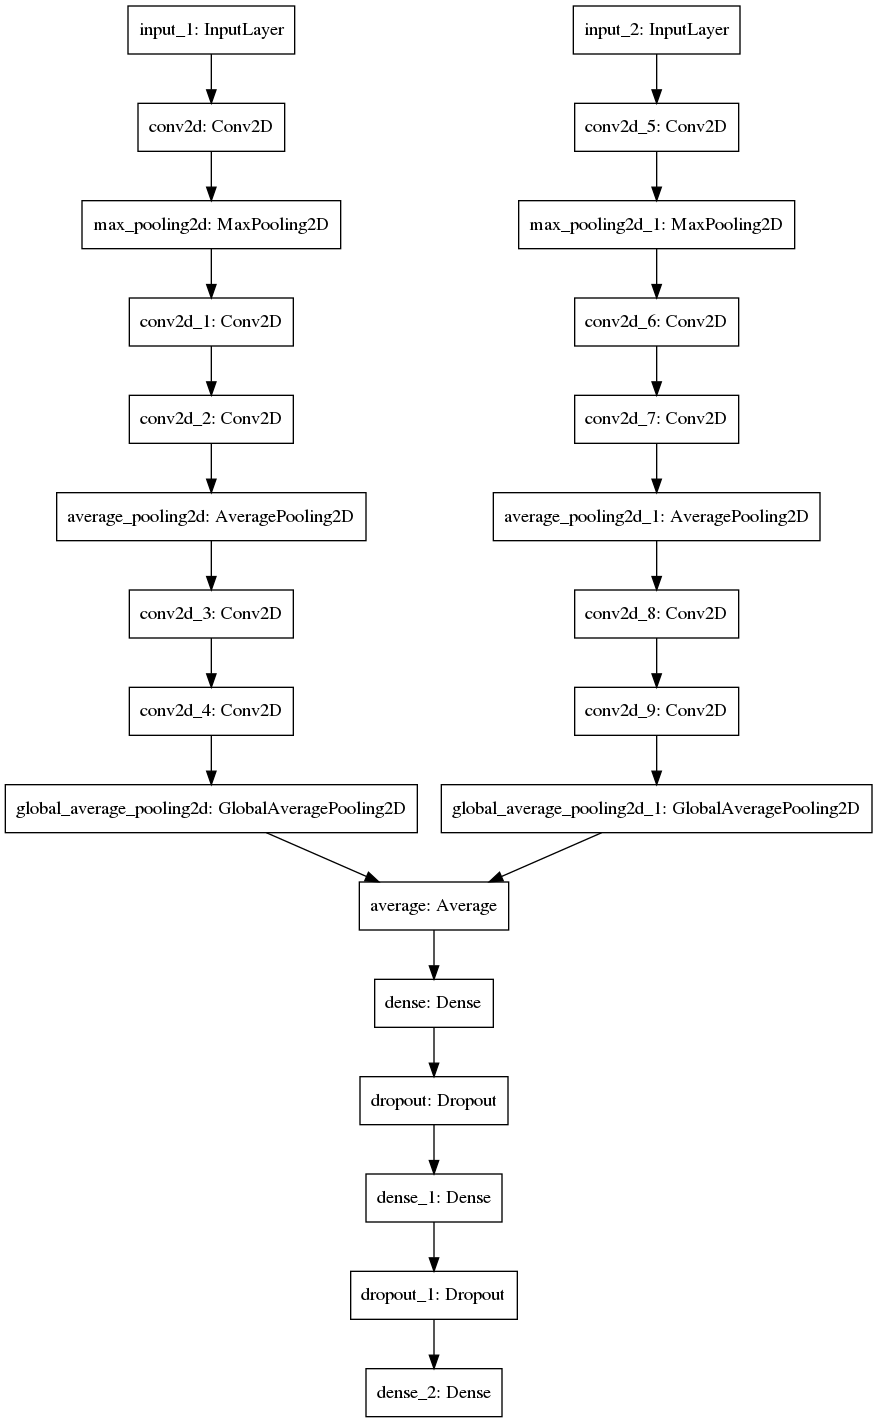

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
'''
# Continue training starting from last saved model
from tensorflow.keras.models import load_model

model_dir = baum_dir + 'models/'
model_path  = model_dir + 'Model_fusion_GAP_sum_20.h5'

# load and evaluate a saved model
model = load_model(model_path)
'''

from tensorflow.keras import optimizers
optimizer_ = optimizers.RMSprop(lr=0.00001, rho=0.9)

model.compile(optimizer=optimizer_,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add checkpoint for model saver
model_dir = baum_dir + 'models/'
#filepath=model_dir + 'Model_fusion_flatten_sum_{epoch:02d}.h5'
filepath=model_dir + 'Model_fusion_GAP_average.h5'

checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')

from tensorflow.keras.callbacks import Callback
class WeightsSaver(Callback):
  def __init__(self, N):
    self.N = N
    self.epoch = 0

  def on_epoch_end(self, epoch, logs={}):
    if self.epoch % self.N == 0 and self.epoch > 15:
      name = model_dir + 'Model_fusion_GAP_average_%03d.h5' % self.epoch
      self.model.save(name)
      print("Saving model ..  ", self.epoch )
    self.epoch += 1
    

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=2, min_lr=0.00001, mode = 'max', verbose = 1)

callbacks_list = [checkpoint, reduce_lr, WeightsSaver(5)]
 
steps_per_epoch_train = int(len(train_df) / batch_size_) ###?###
steps_per_epoch_valid = int(len(valid_df) / batch_size_) ###?###

print("train data length ", len(train_df), " valid data length ", len(valid_df))    
print("steps_per_epoch", steps_per_epoch_train, steps_per_epoch_valid)    
print("batch size: ", batch_size_, " Image size: ", target_size_)    

    


train data length  64797  valid data length  9199
steps_per_epoch 253 35
batch size:  256  Image size:  48


In [0]:
# Train Model
# 
history = model.fit_generator(
        train_generator,
        steps_per_epoch = steps_per_epoch_train, 
        epochs = 60,
        validation_data  = validation_generator,
        validation_steps = steps_per_epoch_valid, 
        callbacks = callbacks_list)

Epoch 1/60
 35/253 [===>..........................] - ETA: 2:37 - loss: 45.7580 - acc: 0.0790
Epoch 00001: val_acc improved from -inf to 0.07902, saving model to /home/carkyo/Downloads/FER/BAUM/models/Model_fusion_GAP_average.h5
253/253 [==============================] - 205s 810ms/step - loss: 49.1382 - acc: 0.2999 - val_loss: 45.7580 - val_acc: 0.0790
Epoch 2/60
 35/253 [===>..........................] - ETA: 2:37 - loss: 39.6167 - acc: 0.0800
Epoch 00002: val_acc improved from 0.07902 to 0.08002, saving model to /home/carkyo/Downloads/FER/BAUM/models/Model_fusion_GAP_average.h5
253/253 [==============================] - 197s 780ms/step - loss: 42.6484 - acc: 0.3052 - val_loss: 39.6167 - val_acc: 0.0800
Epoch 3/60
 35/253 [===>..........................] - ETA: 2:37 - loss: 34.0924 - acc: 0.0807
Epoch 00003: val_acc improved from 0.08002 to 0.08069, saving model to /home/carkyo/Downloads/FER/BAUM/models/Model_fusion_GAP_average.h5
253/253 [==============================] - 198s 784ms

 35/253 [===>..........................] - ETA: 2:37 - loss: 1.6289 - acc: 0.5566
Epoch 00021: val_acc did not improve from 0.56507
Saving model ..   20
253/253 [==============================] - 198s 781ms/step - loss: 1.6793 - acc: 0.4641 - val_loss: 1.6289 - val_acc: 0.5566
Epoch 22/60
 35/253 [===>..........................] - ETA: 2:37 - loss: 1.5685 - acc: 0.5652
Epoch 00022: val_acc improved from 0.56507 to 0.56518, saving model to /home/carkyo/Downloads/FER/BAUM/models/Model_fusion_GAP_average.h5
253/253 [==============================] - 197s 781ms/step - loss: 1.6207 - acc: 0.4653 - val_loss: 1.5685 - val_acc: 0.5652
Epoch 23/60
 35/253 [===>..........................] - ETA: 2:38 - loss: 1.5607 - acc: 0.5556
Epoch 00023: val_acc did not improve from 0.56518
253/253 [==============================] - 198s 781ms/step - loss: 1.5781 - acc: 0.4680 - val_loss: 1.5607 - val_acc: 0.5556
Epoch 24/60
 35/253 [===>..........................] - ETA: 2:39 - loss: 1.4846 - acc: 0.5754
Ep

 35/253 [===>..........................] - ETA: 2:38 - loss: 1.3662 - acc: 0.5643
Epoch 00042: val_acc did not improve from 0.58170
253/253 [==============================] - 197s 780ms/step - loss: 1.3306 - acc: 0.5023 - val_loss: 1.3662 - val_acc: 0.5643
Epoch 43/60
 35/253 [===>..........................] - ETA: 2:40 - loss: 1.3338 - acc: 0.5761
Epoch 00043: val_acc did not improve from 0.58170
253/253 [==============================] - 198s 782ms/step - loss: 1.3245 - acc: 0.5045 - val_loss: 1.3338 - val_acc: 0.5761
Epoch 44/60
 35/253 [===>..........................] - ETA: 2:37 - loss: 1.3953 - acc: 0.5463
Epoch 00044: val_acc did not improve from 0.58170
253/253 [==============================] - 197s 780ms/step - loss: 1.3195 - acc: 0.5068 - val_loss: 1.3953 - val_acc: 0.5463
Epoch 45/60
 35/253 [===>..........................] - ETA: 2:38 - loss: 1.3120 - acc: 0.5771
Epoch 00045: val_acc did not improve from 0.58170
253/253 [==============================] - 198s 783ms/step - 

In [0]:
filepath=model_dir + 'Model_fusion_GAP_average_end.h5'
model.save(filepath)

### **End Training**

### Analyze training

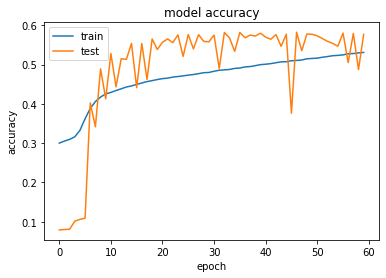

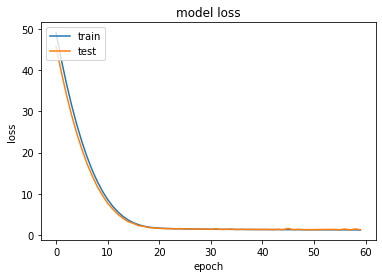

In [0]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Test Model
#### load Model


In [0]:
from tensorflow.keras.models import load_model

home_dir = '/home/carkyo/Downloads/FER/'
baum_dir = home_dir + 'BAUM/'
model_dir = baum_dir + 'models/'
model_path  = model_dir + 'Model_GAP_average.h5'

# load and evaluate a saved model
loaded_model = load_model(model_path)
# summarize model.
#loaded_model.summary()

#### Fusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np
P = loaded_model.predict_generator(generator=validation_generator, max_queue_size =10, verbose=1, steps=35)
y_predict = np.argmax(P, axis=1)
print(len(y_predict))


35/35 [==============================] - 25s 711ms/step
8960


In [0]:
y_true = validation_generator_spatial_2.classes[:len(y_predict)]

8960 8960


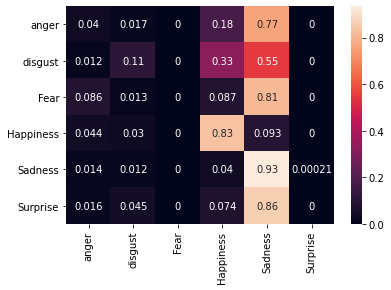

In [0]:

#y_true = validation_generator.classes

print(len(y_predict), len(y_true))
cm = confusion_matrix(y_true, y_predict)
import seaborn as sns
emotions = ['anger' , 'disgust' , 'Fear' , 'Happiness', 'Sadness', 'Surprise']
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, xticklabels=emotions, yticklabels=emotions)

### Test Video

In [0]:
from tensorflow.keras.models import load_model

home_dir = '/home/carkyo/Downloads/FER/'
baum_dir = home_dir + "BAUM/"
model_dir = baum_dir + 'models/'
model_path  = model_dir + 'Model_fusion_GAP_sum.h5'

# load and evaluate a saved model
loaded_model = load_model(model_path)

# Needed Functions
# Create a face detec tion module 
calssifiers =['haarcascade_frontalface_default.xml',
              'haarcascade_frontalface_alt2.xml',
              'haarcascade_frontalcatface_extended.xml',
              'haarcascade_frontalcatface.xml',
              'haarcascade_frontalface_alt_tree.xml',
              'haarcascade_frontalface_alt.xml']

def detectFace(img):
    for classifier in calssifiers:
        face_cascade = cv2.CascadeClassifier(home_dir +'face_detectors/' + classifier)
        faces = face_cascade.detectMultiScale(img, 1.3, 1)
        if (len(faces) > 0):
            return faces
    faces = []
    return faces

In [0]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from random import randint
from random import seed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython import display
import os
from  builtins import any as b_any
#seed(2)
temp_image = np.array([])
none_image = None

videos = glob(baum_dir+'BAUM1s_MP4 - All/*/*.mp4')
emotions = ['Anger', 'Sadness', 'Surprise', 'Disgust', 'Fear', 'Happiness']

data_labels_xl =  pd.read_excel(baum_dir + "Annotations_BAUM1s.xlsx")
data_labels = np.array(data_labels_xl)

#print (vid)
# Assert Video Code
val = randint(0, len(videos)-1)
#print (len(videos))
vid = videos[val]
vidName = vid.split('/')[-1].split('.')[0]
vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])
#print(list(valid_df['flow']))
#while vidCode not in ([1, 10, 11, 6, 7, 8]):
while vidCode not in ([1, 10, 11, 6, 7, 8]) and (not b_any(vidLabel in x for x in list(valid_df['flow']))):
  val = randint(0, len(videos))
  vid = videos[val]
  vidName = vid.split('/')[-1].split('.')[0]
  #print (vidName)
  try:
    vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
    vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])
  except:
    print ("Video Emotion Not Found")
print ('Video Name: {} Label: {}'.format(vidName, vidLabel))

video_output = baum_dir +'output.mp4'
cap = cv2.VideoCapture(vid)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_gray = cv2.resize(old_gray, (100,100))

clip = VideoFileClip(vid)

count_frames = 0
calcOpticalFlow = -1
def process_image_challenge(frame):
  global calcOpticalFlow, old_gray, count_frames
  count_frames += 1
  #if isinstance(frame, type(temp_image)) and not isinstance(frame, type(none_image)) :
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  #print(frame_gray.shape)
  faces = detectFace(frame_gray)
  if len(faces) == 0:
      calcOpticalFlow = 0
      print("Old frame due to no faces")
      return frame #return original frame of video

  (x,y,w,h)  = faces[0]
  frame_gray = frame_gray[y:y+h, x:x+w]
  roi_color = frame[y:y+h, x:x+w]

  if(frame_gray.shape[0] < 90 or roi_color.shape[0] < 90 ):
      print("Old frame due to small size")
      calcOpticalFlow = 0
      return frame #return original frame of video

  frame_gray = cv2.resize(frame_gray, (100,100))
  roi_color = cv2.resize(roi_color, (100,100))

  calcOpticalFlow += 1
  hsv = np.zeros_like(roi_color)
  hsv[...,1] = 255

  if (calcOpticalFlow > 1 ):
    flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)            
    mag, ang   = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    flowImg = cv2.resize(rgb, (48,48))
    flowImg = flowImg.reshape(-1, 48,48,3)
    roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
    spatialImg = cv2.resize(roi_color, (48,48))
    spatialImg = spatialImg.reshape(-1, 48,48,3)
    spatialImg = spatialImg *1 / 255.0
    flowImg = flowImg * 1 / 255.0
    out = loaded_model.predict([spatialImg, flowImg])
    org = (50, 50)   
    # fontScale 
    fontScale = 1 
    font = cv2.FONT_HERSHEY_SIMPLEX      
    # Blue color in BGR 
    color = (255, 0, 0)   
    # Line thickness of 2 px 
    thickness = 2    
    # Using cv2.putText() method 
    txt = 'Ground Truth: {}, Out: {}'.format(vidLabel, emotions[np.argmax(out[0])])
    #print ('True: {}, Out: {}, Prob.: {}'.format(vidLabel, emotions[np.argmax(out[0])], out[0]))
    frame = cv2.putText(frame, txt, org, font,  
                      fontScale, color, thickness, cv2.LINE_AA) 
 
  old_gray = frame_gray.copy()
  return frame

challenge_clip = clip.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(video_output, audio=False)
print(count_frames , frameCount)
print("The random index is ", val)

Video Name: S021_086 Label: Sadness


t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]

Moviepy - Building video /home/carkyo/Downloads/FER/BAUM/output.mp4.
Moviepy - Writing video /home/carkyo/Downloads/FER/BAUM/output.mp4



Moviepy - Done !
Moviepy - video ready /home/carkyo/Downloads/FER/BAUM/output.mp4
CPU times: user 8.1 s, sys: 245 ms, total: 8.35 s
Wall time: 2.99 s
62 60
The random index is  151


In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_output,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)